In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import json

from segmentation_paper_results_methods import compute_mask_metrics, get_features, \
                                               get_feature_array, cross_validate, \
                                               cross_validate_filtering_results, \
                                               cross_validate_baseline_filtering_results, \
                                               check_class_order

pd.set_option('display.precision', 3)
np.set_printoptions(precision=3)


In [2]:
# Define path to annotations and parameters for analysis

# Manual prompts
#dataset_path = "data/annotations_bounding_box_prompted/"
#prompt_method = 'Manual'  # used in plot titles

# Automatic segmentation
dataset_path = "data/annotations_automatic/"
prompt_method = 'Automatic'  # used in plot titles

# Baseline filtering parameters
BASELINE_FILTER_MIN = 1000
BASELINE_FILTER_MAX = 25000

In [3]:
# Analysis parameters
classes = ['fish', 'incorrect', 'head', 'multiple']  # class names to use in annotations
display_classes = ['Fish', 'Incorrect', 'Head', 'Multiple']  # class names in figures
colors = {'fish': 'blue', 'incorrect': 'red', 'head': 'yellow', 'multiple': 'purple'}  # for visualization
rs = 43  # random seed
path = dataset_path
os.listdir(path)

['annotations_automatic.json']

In [4]:
# Images data
imgs_path = "data/images/"
imgs = os.listdir(imgs_path)
imgs = [i.split('.png')[0] for i in imgs]

# Four different cameras / data sources
cam2 = [i for i in imgs if (i.startswith('camera2') or i.startswith('vlc'))]
cam3 = [i for i in imgs if i.startswith('camera3')]
top = [i for i in imgs if i.startswith('top')]
bottom = [i for i in imgs if i.startswith('bottom')]

print(len(cam2), len(cam3), len(top), len(bottom), len(imgs))

37 29 15 7 88


In [5]:
CLASS_ID_MAP = {
    'fish': 0,
    'bad': 1,
    'head': 2,
    'double': 3
}

# Read annotations from the .json file, coco format expected
for file in os.listdir(path):
    if not file.endswith('.json'):
        continue
    f = open(path + file)
    all_data = json.load(f)
    print(all_data.keys())
    print(all_data['images'][0])
    print(all_data['annotations'][0])

    img_files = pd.DataFrame(all_data['images'])
    # Create a mapping from CVAT's category_id to category_name
    id_to_name = {c['id']: c['name'] for c in all_data['categories']}
    
    for a in all_data['annotations']:
        masks = a['segmentation']['counts']
        a['segmentation'] = masks

        # Map category_id to consistent category_name
        a['category_name'] = id_to_name[a['category_id']]

        # Map category_name to canonical class ID
        a['category_id'] = CLASS_ID_MAP[a['category_name']]

        # Use more appropriate naming instead of bad/double in source data
        if a['category_name'] == 'bad':
            a['category_name'] = 'incorrect'
        if a['category_name'] == 'double':
            a['category_name'] = 'multiple'

        file_name = img_files[img_files['id'] == a['image_id']]['file_name'].values[0]
        a['file_name'] = file_name
        a['camera'] = file_name.split('_')[0]

df = pd.DataFrame(all_data['annotations'])

# Uncomment one line to run the analysis for only one farm
#df = df[(df['camera'] == 'bottom')]

# Sanity check print
df.head()

dict_keys(['licenses', 'info', 'categories', 'images', 'annotations'])
{'id': 1, 'width': 2000, 'height': 1159, 'file_name': 'bottom_2022-4-24_02-18-00_002200.png', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}
{'id': 1, 'image_id': 1, 'category_id': 1, 'segmentation': {'counts': [666811, 4, 1154, 7, 1152, 9, 1149, 12, 1147, 13, 1146, 14, 1144, 16, 1143, 16, 1143, 15, 1143, 16, 1143, 16, 1143, 15, 1143, 16, 1143, 16, 1142, 16, 1143, 16, 1143, 16, 1143, 15, 1144, 15, 1144, 14, 1144, 15, 1144, 14, 1145, 14, 1145, 13, 1145, 13, 1146, 13, 1146, 12, 1147, 11, 1148, 11, 1147, 11, 1148, 11, 1148, 11, 1148, 10, 1148, 11, 1148, 11, 1148, 11, 1147, 12, 1147, 11, 1147, 12, 1147, 12, 1147, 12, 1146, 13, 1146, 13, 1145, 13, 1146, 13, 1146, 13, 1145, 14, 1145, 14, 1144, 15, 1144, 15, 1144, 15, 1143, 16, 1143, 16, 1142, 17, 1142, 17, 1142, 17, 1141, 18, 1141, 18, 1141, 18, 1141, 18, 1140, 19, 1140, 19, 1140, 19, 1140, 19, 1139, 20, 1139, 20, 1139, 20, 1138, 21, 1138, 21, 1137, 2

,id,image_id,category_id,segmentation,area,bbox,iscrowd,attributes,category_name,file_name,camera
0,1,1,0,"[666811, 4, 1154, 7, 1152, 9, 1149, 12, 1147, ...",7319.0,"[575.0, 357.0, 290.0, 44.0]",1,{'occluded': False},fish,bottom_2022-4-24_02-18-00_002200.png,bottom
1,2,1,0,"[481247, 3, 1156, 5, 1153, 7, 1152, 7, 1152, 7...",7870.0,"[415.0, 182.0, 282.0, 86.0]",1,{'occluded': False},fish,bottom_2022-4-24_02-18-00_002200.png,bottom
2,3,1,2,"[749217, 2, 1155, 5, 1151, 9, 1148, 12, 1145, ...",3093.0,"[646.0, 449.0, 97.0, 61.0]",1,{'occluded': False},head,bottom_2022-4-24_02-18-00_002200.png,bottom
3,4,1,1,"[59572, 7, 1150, 13, 1145, 15, 1143, 17, 1142,...",496.0,"[51.0, 457.0, 26.0, 24.0]",1,{'occluded': False},incorrect,bottom_2022-4-24_02-18-00_002200.png,bottom
4,5,1,0,"[274448, 2, 1155, 6, 1152, 7, 1150, 10, 1148, ...",6252.0,"[236.0, 911.0, 197.0, 156.0]",1,{'occluded': False},fish,bottom_2022-4-24_02-18-00_002200.png,bottom


In [6]:
# N
df.count()

id               6376
image_id         6376
category_id      6376
segmentation     6376
area             6376
bbox             6376
iscrowd          6376
attributes       6376
category_name    6376
file_name        6376
camera           6376
dtype: int64

In [7]:
# true class count of whole dataset before any processing
df.groupby(['category_id', 'category_name'])['id'].count()

category_id  category_name
0            fish             3182
1            incorrect        1278
2            head              674
3            multiple         1242
Name: id, dtype: int64

In [8]:
gt = df.groupby(['category_name'])['image_id'].count().to_dict()
ground_truth_order = [gt['fish'], gt['incorrect'], gt['head'], gt['multiple']]

In [9]:
# true class distribution of whole dataset before any processing
df.groupby(['category_name'])['iscrowd'].count() / df['iscrowd'].count()

category_name
fish         0.499
head         0.106
incorrect    0.200
multiple     0.195
Name: iscrowd, dtype: float64

In [10]:
# Compute mask features
mask_metrics = compute_mask_metrics(imgs, imgs_path, df, img_files, classes)
features = get_features(mask_metrics, classes)
X, y = get_feature_array(features)
check_class_order([len(c) for c in features], ground_truth_order)

too few points in hull to fit ellipse data/images/top_2022-4-28_02-18-00_002600.png
too few points in hull to fit ellipse data/images/camera3_2022-06-23_16-04-55_002500.png
too few points in hull to fit ellipse data/images/top_2022-6-1_11-18-00_002000.png
too few points in hull to fit ellipse data/images/camera3_2022-06-25_05-03-23_002500.png
too few points in hull to fit ellipse data/images/camera3_2022-06-17_16-03-11_002000.png
fish df len 3182
incorrect df len 1278
head df len 674
multiple df len 1242
lens 0: 3182 , 1: 1278 , 2: 674 , 3: 1242
[3182, 1278, 674, 1242]
[3182, 1278, 674, 1242]
Class order consistent


plt plot class counts:  [3182, 1123, 674, 1242]


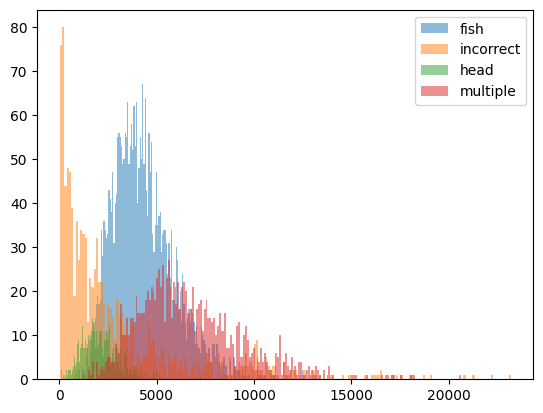

         Class  Mask area
0         fish     5936.0
1         fish     7261.0
2         fish     5423.5
3         fish     6022.5
4         fish     1678.5
...        ...        ...
6216  multiple     4945.5
6217  multiple     5350.5
6218  multiple     8418.5
6219  multiple     7255.0
6220  multiple     6875.0

[6221 rows x 2 columns]


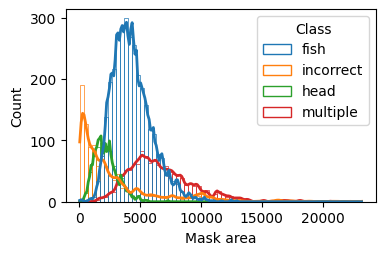

In [11]:
# Area KDE over histogram

maj_all, min_all, areas_all, n_cont_all, n_conv_all, moms_all  = mask_metrics
# fish, incorrect, head, multiple
display_classes = classes

hist_data = [
    areas_all['fish'],
    [a for a in areas_all['incorrect'] if a < BASELINE_FILTER_MAX],
    areas_all['head'],
    areas_all['multiple']
]
print('plt plot class counts: ', [len(h) for h in hist_data])

# Correct histogram, sanity check
for h in hist_data:
    plt.hist(h, alpha=0.5, bins=200)
plt.legend(display_classes)
plt.show()

areas_tuples = []
for cat, clss_data in zip(display_classes, hist_data):
    areas_tuples.extend([(cat, a) for a in clss_data])

df_area_plot = pd.DataFrame(areas_tuples, columns=['Class', 'Mask area'])
print(df_area_plot)

# More visually appealing histogram for the article
plt.figure(figsize=(4, 2.5))
sns_plot = sns.histplot(
    data=df_area_plot,
    x='Mask area',
    hue='Class',
    kde=True,
    kde_kws={'bw_adjust': 0.25},
    fill=False,
    line_kws={'lw': 2},
    alpha=1,
    )

sns_plot.figure.savefig('figure8_left.pdf', dpi=600, bbox_inches='tight', format='pdf')

plt.show()

0.9942501735932361
  Class  2nd Hu moment invariant
0  fish                    0.316
1  fish                    0.658
2  fish                    0.210
3  fish                    0.292
4  fish                    0.146


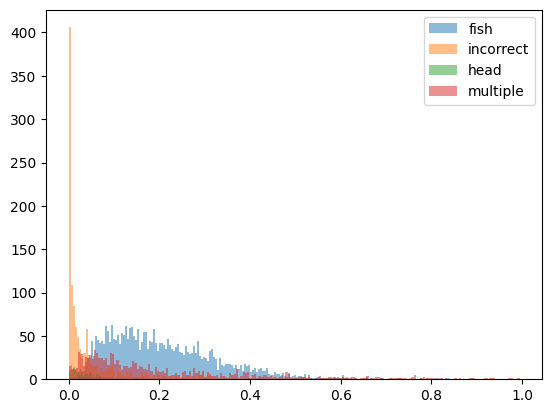

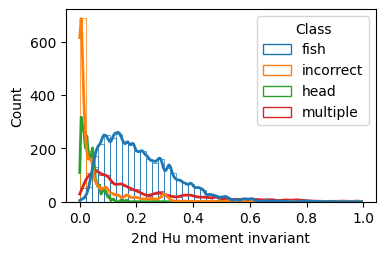

In [12]:
# Maj KDE over histogram

maj_all, min_all, areas_all, n_cont_all, n_conv_all, moms_all  = mask_metrics

hist_data = [
    moms_all['fish'],
    moms_all['incorrect'],
    moms_all['head'],
    moms_all['multiple']
]

mom_tuples = []
for cat, clss_data in zip(display_classes, hist_data):
    mom_tuples.extend([(cat, a[1]) for a in clss_data if a[1] < 1])

df_mom_plot = pd.DataFrame(mom_tuples, columns=['Class', '2nd Hu moment invariant'])

print(df_mom_plot['2nd Hu moment invariant'].max())
print(df_mom_plot.head())

# Correct histogram
for d in display_classes:
    plt.hist(df_mom_plot[df_mom_plot['Class'] == d]['2nd Hu moment invariant'].values, alpha=0.5, bins=200)
plt.legend(display_classes)
plt.show()


plt.figure(figsize=(4, 2.5))
sns_plot = sns.histplot(
    data=df_mom_plot,
    x='2nd Hu moment invariant',
    hue='Class',
    kde=True,
    kde_kws={'bw_adjust': 0.25},
    fill=False,
    line_kws={'lw': 2},
    alpha=1)

sns_plot.figure.savefig('figure8_right.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.show()

In [13]:
# Baseline filtering results for the whole dataset (sanity check, no cross-validation here)
filtered_masks = []
for i, seg in df.iterrows():
    if (seg['area'] < BASELINE_FILTER_MAX) and (seg['area'] > BASELINE_FILTER_MIN):
        filtered_masks.append(seg)

baseline_filtered_df = pd.DataFrame(filtered_masks)
print('N', baseline_filtered_df['iscrowd'].count())
print('Distribution of classes \n', \
      baseline_filtered_df.groupby(['category_name'])['iscrowd'].count() / baseline_filtered_df['iscrowd'].count())

N 5786
Distribution of classes 
 category_name
fish         0.549
head         0.109
incorrect    0.127
multiple     0.215
Name: iscrowd, dtype: float64


In [14]:
baseline_filtered_df.groupby(['category_name'])['iscrowd'].count() 

category_name
fish         3176
head          631
incorrect     737
multiple     1242
Name: iscrowd, dtype: int64

In [15]:
cross_validate(X, y, 0, rs, classes)

One-vs-all binary classification, class 0 : fish vs all
Cross-validation, model KNeighborsClassifier(n_neighbors=3)
0.791 accuracy with a standard deviation of 0.005
Cross-validation, model MLPClassifier(alpha=0.05, max_iter=5000, random_state=43)
0.834 accuracy with a standard deviation of 0.005
Cross-validation, model RandomForestClassifier(max_depth=10, max_features=3, n_estimators=20,
                       random_state=43)
0.842 accuracy with a standard deviation of 0.011


In [16]:
cross_validate(X, y, 1, rs, classes)

One-vs-all binary classification, class 1 : incorrect vs all
Cross-validation, model KNeighborsClassifier(n_neighbors=3)
0.880 accuracy with a standard deviation of 0.005
Cross-validation, model MLPClassifier(alpha=0.05, max_iter=5000, random_state=43)
0.897 accuracy with a standard deviation of 0.005
Cross-validation, model RandomForestClassifier(max_depth=10, max_features=3, n_estimators=20,
                       random_state=43)
0.902 accuracy with a standard deviation of 0.009


In [17]:
cross_validate(X, y, 2, rs, classes)

One-vs-all binary classification, class 2 : head vs all
Cross-validation, model KNeighborsClassifier(n_neighbors=3)
0.906 accuracy with a standard deviation of 0.004
Cross-validation, model MLPClassifier(alpha=0.05, max_iter=5000, random_state=43)
0.917 accuracy with a standard deviation of 0.002
Cross-validation, model RandomForestClassifier(max_depth=10, max_features=3, n_estimators=20,
                       random_state=43)
0.926 accuracy with a standard deviation of 0.003


In [18]:
cross_validate(X, y, 3, rs, classes)

One-vs-all binary classification, class 3 : multiple vs all
Cross-validation, model KNeighborsClassifier(n_neighbors=3)
0.821 accuracy with a standard deviation of 0.009
Cross-validation, model MLPClassifier(alpha=0.05, max_iter=5000, random_state=43)
0.863 accuracy with a standard deviation of 0.009
Cross-validation, model RandomForestClassifier(max_depth=10, max_features=3, n_estimators=20,
                       random_state=43)
0.861 accuracy with a standard deviation of 0.007


In [19]:
# Cross-validated baseline filtering performance: SIZE ONLY
scores_f, scores_fh, scores_fhm, scores_tf, scores_tfh = cross_validate_baseline_filtering_results(df, rs, \
                                                                                                   BASELINE_FILTER_MAX, BASELINE_FILTER_MIN, \
                                                                                                   ground_truth_order)

print('\nBASELINE RESULTS')
print('\nFish %, mean and std: ', "{:.3f}".format(np.mean(scores_f)), "{:.3f}".format(np.std(scores_f)))
print('Fish+head %, mean and std: ', "{:.3f}".format(np.mean(scores_fh)), "{:.3f}".format(np.std(scores_fh)))
print('Fish+head+multiple %, mean and std: ', "{:.3f}".format(np.mean(scores_fhm)), "{:.3f}".format(np.std(scores_fhm)))

print('\nUnfiltered fish %, mean and std: ', "{:.5f}".format(np.mean(scores_tf)), "{:.5f}".format(np.std(scores_tf)))
print('Unfiltered fish + head %, mean: ', "{:.5f}".format(np.mean(scores_tf) + np.mean(scores_tfh)))

[3182, 1278, 674, 1242]
[3182, 1278, 674, 1242]
Class order consistent
N 6376
Train/test split 5100 / 1276
Train/test split 5101 / 1275
Train/test split 5101 / 1275
Train/test split 5101 / 1275
Train/test split 5101 / 1275

BASELINE RESULTS

Fish %, mean and std:  0.549 0.001
Fish+head %, mean and std:  0.658 0.002
Fish+head+multiple %, mean and std:  0.873 0.002

Unfiltered fish %, mean and std:  0.49906 0.00031
Unfiltered fish + head %, mean:  0.60477


Train/test split 5100 / 1276
Train/test split 5101 / 1275
Train/test split 5101 / 1275
Train/test split 5101 / 1275
Train/test split 5101 / 1275


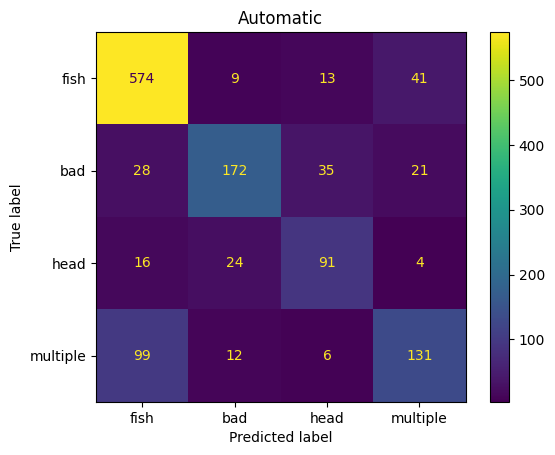


CLASSIFIER FILTERING RESULTS
Fish %, mean and std:  0.701 0.005
Fish+head %, mean and std:  0.775 0.007
Fish+head+multiple %, mean and std:  0.905 0.006


In [20]:
# Cross-validated baseline filtering performance of the RF classifier
scores_f, scores_fh, scores_fhm = cross_validate_filtering_results(X, y, rs, prompt_method, binary=False)
print('\nCLASSIFIER FILTERING RESULTS')
print('Fish %, mean and std: ', "{:.3f}".format(np.mean(scores_f)), "{:.3f}".format(np.std(scores_f)))
print('Fish+head %, mean and std: ', "{:.3f}".format(np.mean(scores_fh)), "{:.3f}".format(np.std(scores_fh)))
print('Fish+head+multiple %, mean and std: ', "{:.3f}".format(np.mean(scores_fhm)), "{:.3f}".format(np.std(scores_fhm)))

